**Se agregan librerías necesarias**

In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
from dtreeviz import clfviz
from sklearn import tree
import numpy as np
import pandas as pd

**Función generar para el conjunto de datos** 

Recibe el número $N$ de instancias a generar por clase, la función de segregación de datos $limFunction$ y el valor límite $R$ para utilizar en esta misma. El parámetro $squareSide$ es para obtener un cuadrado de $squareSide^2$ de área. El parámetro $maxIterations$ solo es para no caer en un loop infinito.

In [2]:
def getDatasets(N=1000, R=1, *, limFunction, squareSide=1, maxIterations=50000):
    # Variables para contar el numero de instancias dentro de cada clase
    inside, outside = 0, 0
    dataPoints = []
    # Se genera la iteracion hasta llenar los datos en cada clase o
    # agotar el numero maximo de iteraciones
    while maxIterations and inside < N or outside < N:
        # Se generan dos puntos aleatorios dentro del area del cuadrado
        x = np.random.uniform(-squareSide,squareSide)
        y = np.random.uniform(-squareSide,squareSide)
        # Si los puntos generados se encuentran dentro de region marcada
        # por la funcion limite pertenecen a la clase 0
        if limFunction(x,y,R):
            if inside < N:
                dataPoints.append([x,y,0])
                inside += 1
        # De lo contrario pertenecen a la clase 1
        else: 
            if outside < N:
                dataPoints.append([x,y,1])
                outside += 1 
        maxIterations -= 1
    return pd.DataFrame(np.array(dataPoints),columns=['X','Y','Class'])

# Generación de los conjuntos de Datos

Primeramente se definen las diferentes funciones para crear las clases. Estas funciónes luego se pasan a la función $getDataset$ para generar cada conjunto.

**Clase Roja**

![circle](circle.png)

In [3]:
# Si los puntos estan dentro del circulo de radio r retorna True, 
# de lo contrario retorna False
circle = lambda x,y,r: x**2+y**2 <= r**2

**Clase Azul**

![square](square.png)

In [4]:
# Si los puntos estan dentro del cuadrado retorna True, 
# de lo contrario retorna False
square = lambda x,y,r: max(abs(x),abs(y)) <= r

**Clase Verde**

![triangle](triangle.png)

Para definir la función el intercepto se redujo para obtener $b=\dfrac{\sqrt{3}}{4}\cdot r$ y la pendiente se redujo para obtener $m=\sqrt3$.

In [5]:
def triangle(x,y,r):
    b = (np.sqrt(3)/4)*r
    m = -np.sqrt(3)
    t1 = y - m*x <= b and y >= -b and x >= 0
    t2 = y + m*x <= b and y >= -b and x <= 0
    return t1 or t2

**Se generan los conjuntos**

Cada conjunto de datos tendrá 2000 instancias de cada clase. Además el valor límite $R$ de los primeros 2 conjuntos (círculo y cuadrado) es 0.9 y 1.7 para el tercer conjunto (triángulo).

In [6]:
dataset1 = getDatasets(N=2000, R=0.9, limFunction=circle)
dataset2 = getDatasets(N=2000, R=0.9, limFunction=square)
dataset3 = getDatasets(N=2000, R=1.7, limFunction=triangle)

**Se grafican los 3 conjuntos con sus colores correspondientes**

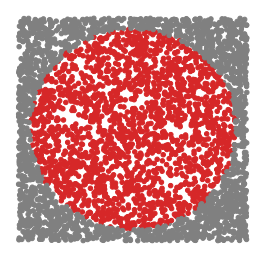

In [7]:
# Clase Roja (2000 pts) / Clase Gris (2000 pts)
cmap = colors.ListedColormap(['tab:red', 'gray'])
dataset1.plot(kind='scatter', x='X', y='Y', c='Class',
              cmap=cmap, figsize=(4.5,4.5), colorbar=False).axis('off');

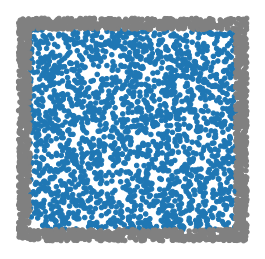

In [8]:
# Clase Azul (2000 pts) / Clase Gris (2000 pts)
cmap = colors.ListedColormap(['tab:blue', 'gray'])
dataset2.plot(kind='scatter', x='X', y='Y', c='Class',
              cmap=cmap, figsize=(4.5,4.5), colorbar=False).axis('off');

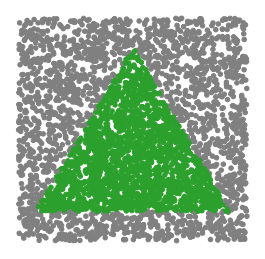

In [9]:
# Clase verde (2000 pts) / Clase Gris (2000 pts)
cmap = colors.ListedColormap(['tab:green', 'gray'])
dataset3.plot(kind='scatter', x='X', y='Y', c='Class',
              cmap=cmap, figsize=(4.5,4.5), colorbar=False).axis('off');

**Función para obtener el árbol de decisión y sus representaciones gráficas**

La función recibe el conjunto de datos, y la máxima profundidad del árbol (por definición es 5), y otros parámetros de visualización. Esta crea, entrena, muestra y retorna el modelo generado con el conjunto de datos.

In [10]:
def getDecisionTree(dataset, *, max_depth=5, class1='Class1', class2='Class2', 
                    color1='#FFFFFF', color2='#808080', markers=['o','D'],
                    treeSize=(15,12)):
    # Se obtienen los atributos y etiquetas como numpy arrays
    X = np.array(dataset.iloc[:,:2])
    y = np.array(dataset.iloc[:,2])
    # Se genera el modelo de arbol de decision
    # Donde se utiliza la entropia como criterio de decision
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=max_depth)
    # Se entrena con el conjunto de datos
    clf.fit(X, y)
    # Se muestra el arbol completo
    fig = plt.figure(figsize=treeSize)
    ax = fig.add_subplot()
    tree.plot_tree(clf, fontsize=15, feature_names=['x','y'], 
                   class_names=[class1,class2], 
                   filled=True, rounded=True, ax=ax);
    # Se grafican los limites de decision
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    clfviz(clf, X, y, feature_names=['x', 'y'], markers=markers, 
           target_name='Clases', ax=ax, class_names=[class1, class2], dot_w=15,
           tile_fraction=1, boundary_marker='o', boundary_markersize=2, 
           fontsize=11, colors={'class_boundary': 'k', 
                                'classes':[None,None, [color1, color2]], 
                                'scatter_edge': 'black'})
    # Se imprime la exactitud del modelo
    print('Mean accuracy:',clf.score(X,y))
    # Retorna el modelo generado
    return clf

**Función para obtener varios árboles de decisión a la vez**

In [11]:
def multDecisionTree(dataset, *, depths, class1='Class1', class2='Class2', 
                    color1='#FFFFFF', color2='#808080', markers=['o','D']):
    # Se obtienen los atributos y etiquetas como numpy arrays
    X = np.array(dataset.iloc[:,:2])
    y = np.array(dataset.iloc[:,2])
    
    fig, axes = plt.subplots(1,len(depths), figsize=(15,5))
    fig.tight_layout()
    # Se obtienen los diferentes arboles de decision segun la profundidad
    for depth, ax in zip(depths,axes):
        # Se genera el modelo de arbol de decision
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          max_depth=depth)
        # Se entrena con el conjunto de datos
        clf.fit(X, y)
        # Se grafican los limites de decision
        clfviz(clf, X, y, feature_names=['x', 'y'], markers=markers, 
               ax=ax, show=['instances', 'boundaries', 'misclassified'],
               dot_w=15, tile_fraction=1, boundary_marker='o', 
               boundary_markersize=2, fontsize=11,
               colors={'class_boundary': 'k', 
                       'classes':[None,None, [color1, color2]], 
                       'scatter_edge': 'black'})
        # Se obtiene la exactitud del modelo
        acc = clf.score(X,y)
        ax.set_title(f'Max Tree depth: {depth}\n Mean accuracy:{round(acc,3)}')

**Se obtiene el árbol de decisión para el primer conjunto (Círculo)**

Mean accuracy: 0.8815


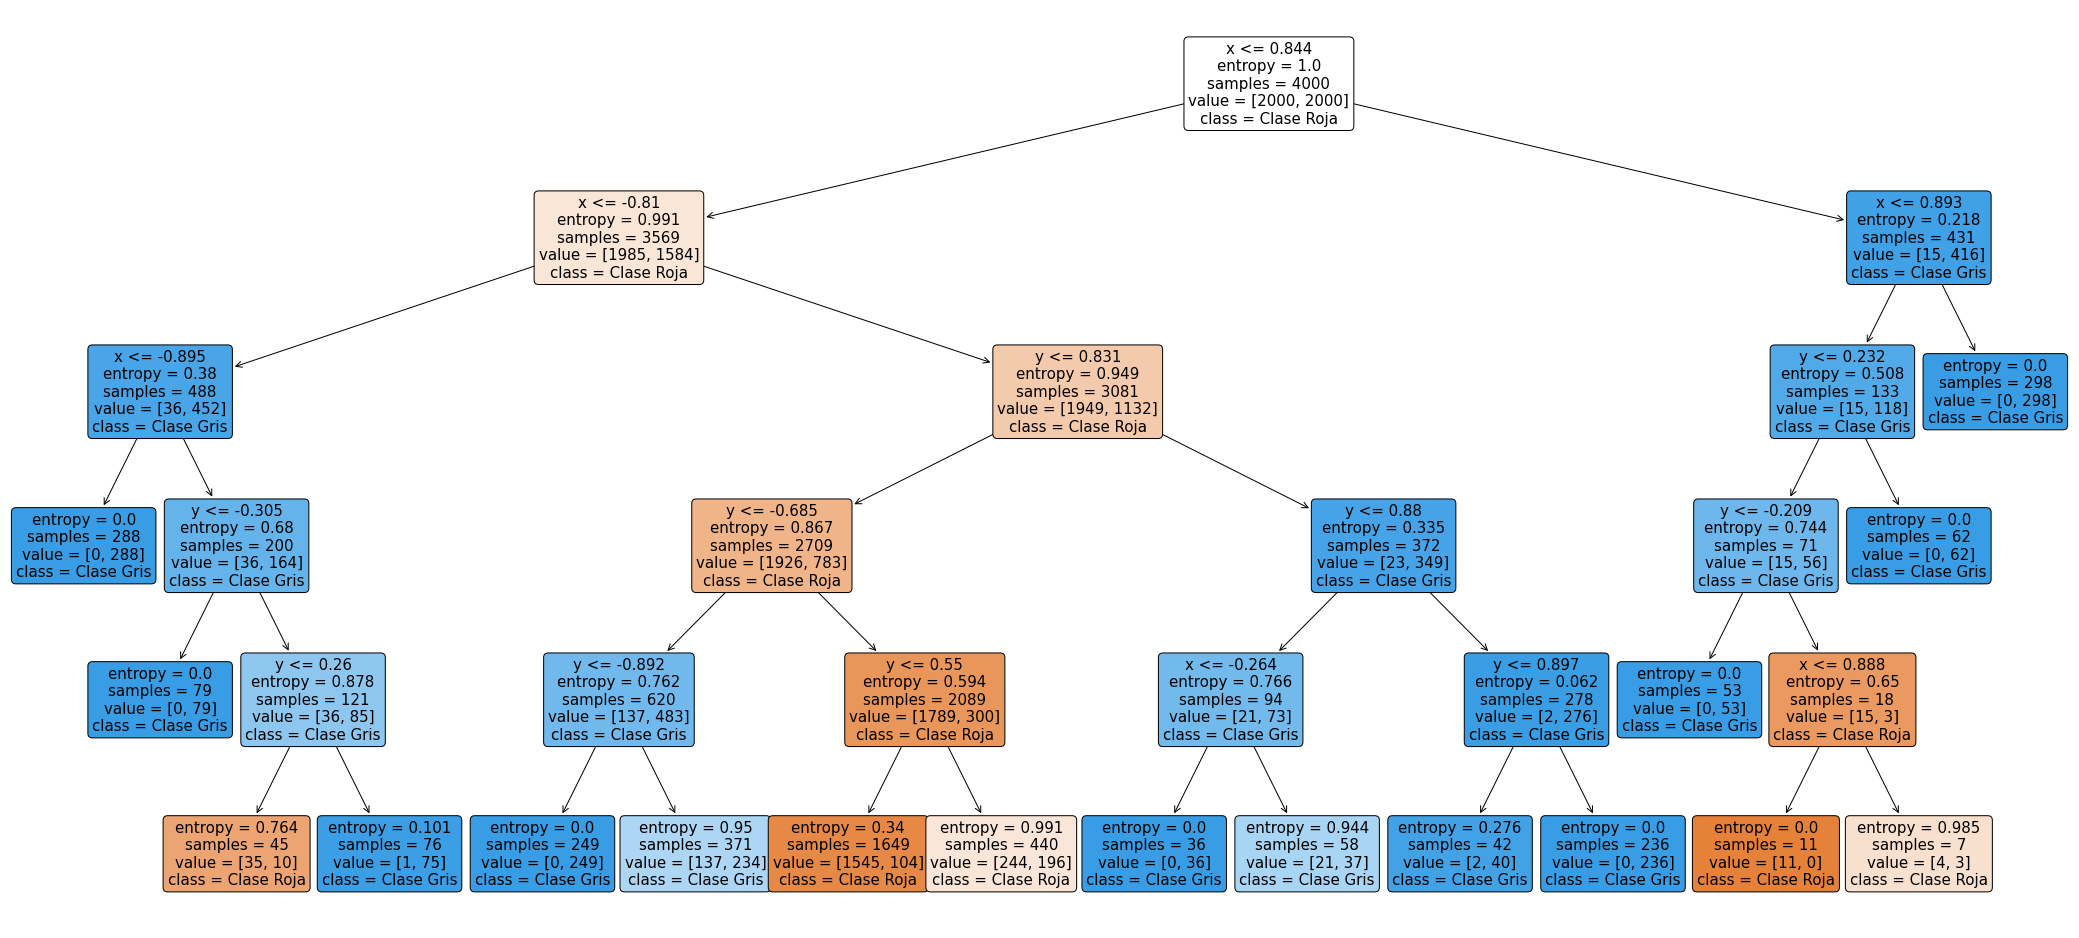

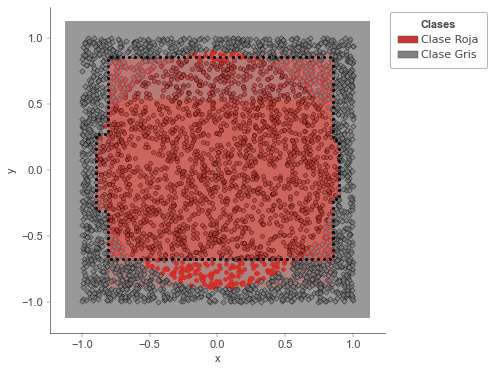

In [12]:
getDecisionTree(dataset1, max_depth=5, class1='Clase Roja', markers=['o','D'],
                class2='Clase Gris', color1='#C53A32', treeSize=(37,17));

**Se obtiene el árbol de decisión para el segundo conjunto (Cuadrado)**

Mean accuracy: 1.0


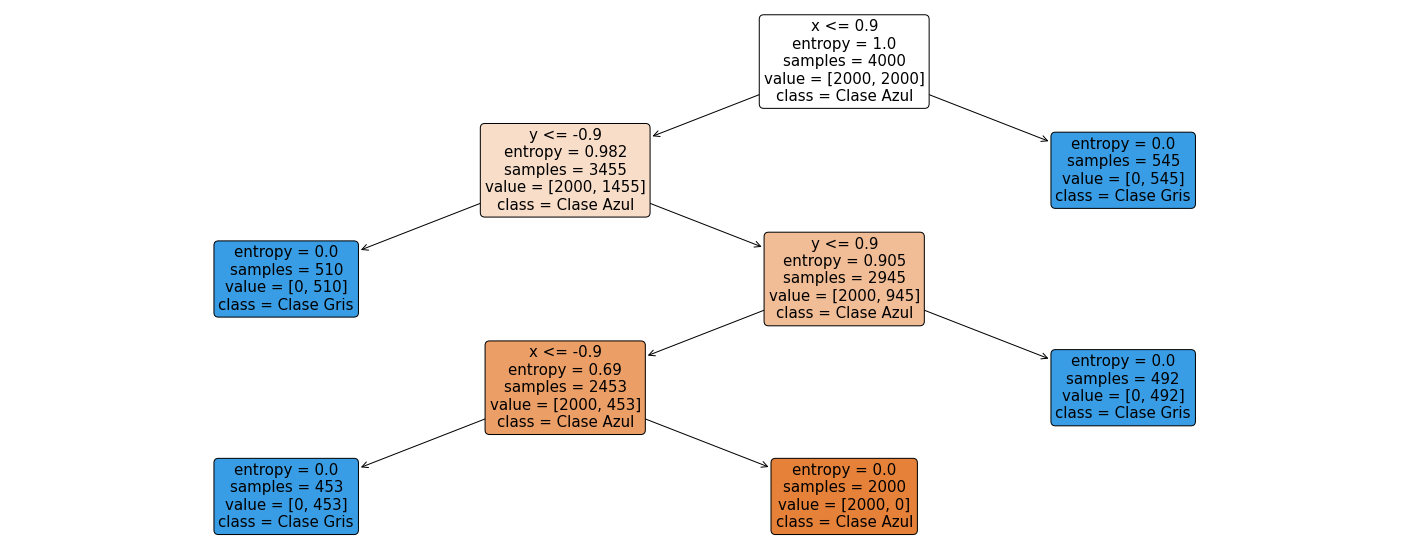

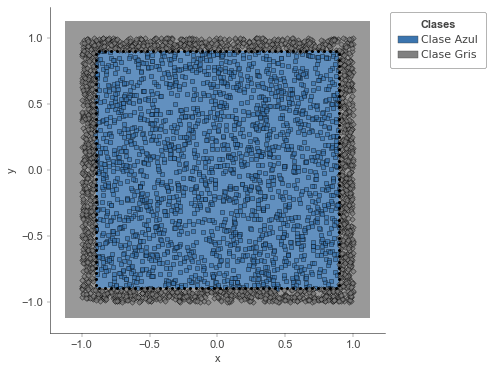

In [13]:
getDecisionTree(dataset2, max_depth=5, class1='Clase Azul', markers=['s','D'],
                class2='Clase Gris', color1='#3B75AF', treeSize=(25,10));

**Se obtiene el árbol de decisión para el primer conjunto (Triángulo)**

Mean accuracy: 0.9025


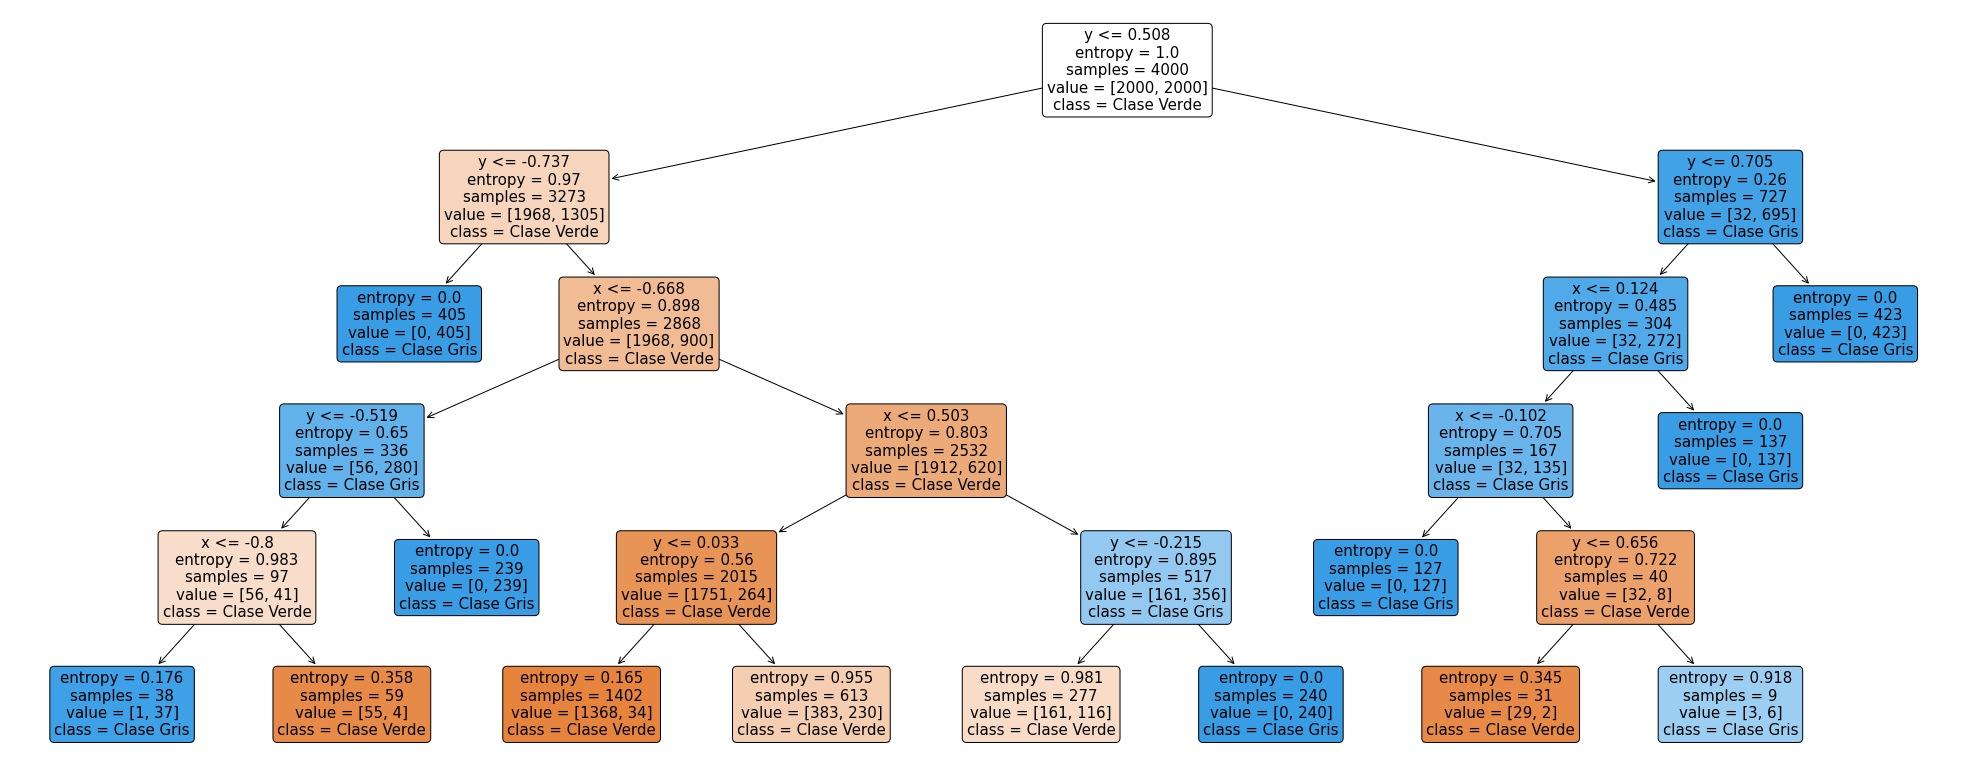

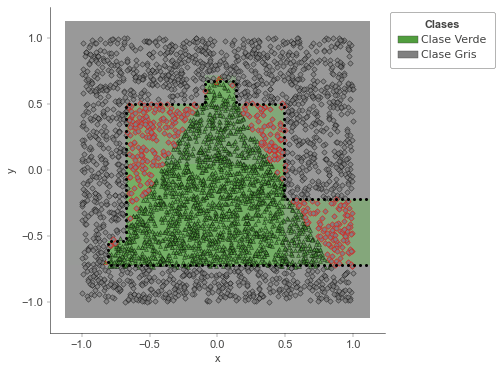

In [14]:
getDecisionTree(dataset3, max_depth=5, class1='Clase Verde', markers=['^','D'],
                class2='Clase Gris', color1='#519E3E', treeSize=(35,14));

**Árboles de desición con diferentes profundidades maximas**

Conjunto de datos 1:

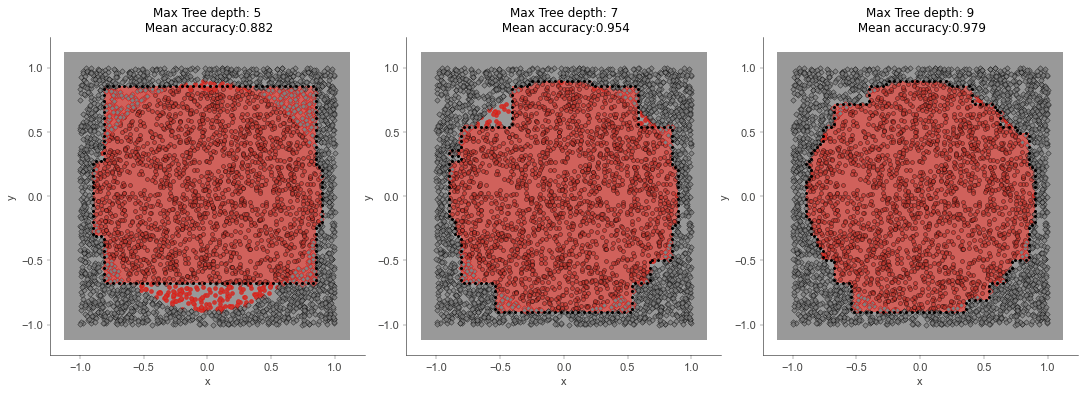

In [15]:
multDecisionTree(dataset1, depths=[5,7,9], markers=['o','D'],color1='#C53A32');

Conjunto de datos 3:

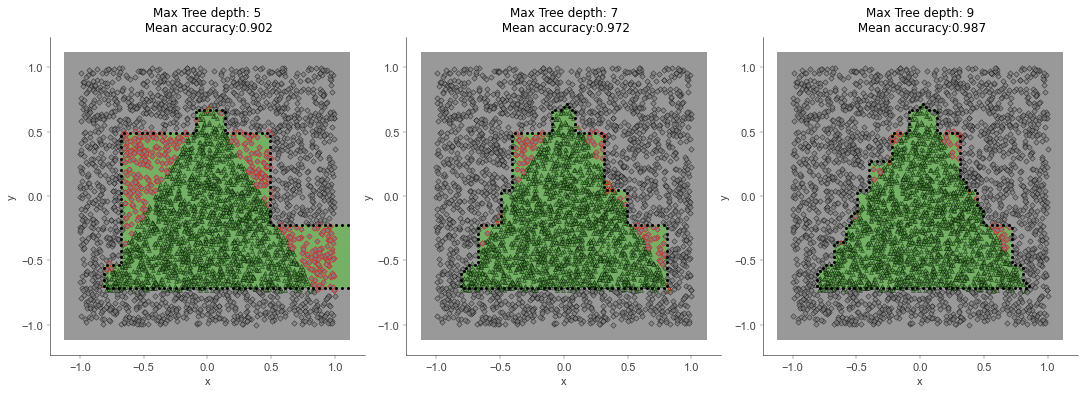

In [16]:
multDecisionTree(dataset3, depths=[5,7,9], markers=['^','D'],color1='#519E3E');